<a href="https://colab.research.google.com/github/georgezoto/Coding-in-TensorFlow/blob/master/Structured%20Data-Credit-Card-Fraud-Detection/Structured_Data_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cassava Disease Classification: Helping farmers identify diseased plants
**Meetup event, come and join us 😀**  
https://www.meetup.com/Deep-Learning-Adventures/events/272091530/

**Deep Learning YouTube recordings, feel free to share and subscribe 😀**  
https://bit.ly/deep-learning-tf  
https://bit.ly/deep-learning-tf-coding  

**Credit Card Fraud Detection Dataset 🎉**   
Anonymized credit card transactions labeled as fraudulent or genuine   
https://www.kaggle.com/mlg-ulb/creditcardfraud


![alt text](https://secure.meetupstatic.com/photos/event/d/b/6/d/highres_491456173.jpeg)

# Inspired by Structured Data - MPG Dataset - Basic regression - Predict fuel efficiency https://www.tensorflow.org/tutorials/keras/regression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

The original notebook used the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [ ]:
# Use seaborn for pairplot
!pip install seaborn

# Use some functions from tensorflow_docs
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import random
seed = 51
tf.random.set_seed(seed)
random.seed(seed)

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

### Get the data
First download the dataset.

In [ ]:
# upload the kaggle.json file from local computer
from google.colab import files
uploaded = files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle --upgrade
!ls -l /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

In [ ]:
!unzip creditcardfraud.zip > /dev/null

In [ ]:
dataset_path = '/content/creditcard.csv'
dataset_path

Import it using pandas

In [ ]:
dataset = pd.read_csv(dataset_path)
dataset.head()

In [151]:
dataset.shape

(284807, 31)

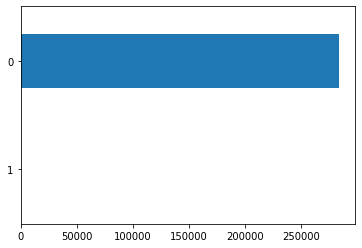

In [152]:
dataset['Class'].value_counts().sort_values().plot(kind = 'barh');

In [153]:
dataset['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [154]:
100*dataset['Class'].value_counts()[1]/dataset['Class'].value_counts()[0]

0.17304750013189596

### Clean the data

Check if the dataset contains unknown values.

In [ ]:
dataset.isna().sum()

In [ ]:
dataset.tail()

### Along with having a common metric, AUPRC, for comparison, it is important to have the same test data to run the metric against. So how about we all use the following approach

In [157]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, stratify=dataset['Class'], test_size=0.2, random_state=51)

In [158]:
print(train_dataset.shape, test_dataset.shape)

(227845, 31) (56962, 31)


### It is not necessary for comparison, but many people will further split the training data into training and validation via something like

In [159]:
train_dataset, validation_dataset = train_test_split(train_dataset, stratify=train_dataset['Class'], test_size=0.2, random_state=51)

In [160]:
print(train_dataset.shape, validation_dataset.shape, test_dataset.shape)

(182276, 31) (45569, 31) (56962, 31)


In [161]:
print(100*train_dataset.shape[0]/dataset.shape[0], 100*validation_dataset.shape[0]/dataset.shape[0], 100*test_dataset.shape[0]/dataset.shape[0])

63.99983146481652 15.99995786620413 20.000210668979342


### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
sns.pairplot(train_dataset[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']], diag_kind="kde", height=3)

In [ ]:
sns.pairplot(train_dataset[['V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']], diag_kind="kde", height=3)

In [ ]:
sns.pairplot(train_dataset[['V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']], diag_kind="kde", height=3)

Also look at the overall statistics:

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("Class")
train_stats = train_stats.transpose()
train_stats

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [ ]:
train_labels = train_dataset.pop('Class')
validation_labels = validation_dataset.pop('Class')
test_labels = test_dataset.pop('Class')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
#normed_train_data = norm(train_dataset)
#normed_test_data = norm(test_dataset)

normed_train_data = train_dataset
normed_validation_data = validation_dataset
normed_test_data = test_dataset

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

In [166]:
def compute_metrics(y_true, y_pred):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(y_true, y_pred)
  tp = int(tp.result().numpy())
  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(y_true, y_pred)
  fp = int(fp.result().numpy())
  tn = tf.keras.metrics.TrueNegatives()
  tn.update_state(y_true, y_pred)
  tn = int(tn.result().numpy())
  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(y_true, y_pred)
  fn = int(fn.result().numpy())
  return [tp, fn, fp, tn]

In [167]:
def print_metrics(metrics):
  print('Fraudulent Transactions Detected (True Positives): ' + str(metrics[0]))
  print('Fraudulent Transactions Missed (False Negatives): ' + str(metrics[1]))
  print('Legitimate Transactions Incorrectly Detected (False Positives): ' + str(metrics[2]))
  print('Legitimate Transactions Detected (True Negatives): ' + str(metrics[3]))

In [179]:
def plot_results(history):
  history = history.history

  fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

  ax1.plot(history['loss'], label='Train loss')
  ax1.plot(history['val_loss'], label='Validation loss')
  ax1.legend(loc='best')
  ax1.set_title('Loss')

  ax2.plot(history['auprc'], label='Train AUPRC')
  ax2.plot(history['val_auprc'], label='Validation AUPRC')
  ax2.legend(loc='best')
  ax2.set_title('AUPRC')

  plt.xlabel('Epochs')
  sns.despine()
  plt.show()

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [168]:
train_dataset.keys()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])
  model.summary()

  return model

In [ ]:
model = build_model()

Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [180]:
checkpoint_filepath = 'Structured-Data-Credit-Card-Fraud-Detection-v1.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                                                      monitor='val_auprc', mode='max', save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

In [182]:
EPOCHS = 10
BATCH_SIZE = 256

tf.keras.backend.clear_session()

history_v1 = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, 
  validation_data = (normed_validation_data, validation_labels), 
  batch_size=BATCH_SIZE,
  verbose=2, 
  callbacks=[model_checkpoint, early_stopping]
  )

Epoch 1/10
713/713 - 5s - loss: 14.3152 - auroc: 0.5064 - auprc: 0.0018 - val_loss: 5.3725 - val_auroc: 0.4999 - val_auprc: 0.0017
Epoch 2/10
713/713 - 5s - loss: 14.6502 - auroc: 0.5103 - auprc: 0.0019 - val_loss: 2.0895 - val_auroc: 0.4997 - val_auprc: 0.0017
Epoch 3/10
713/713 - 5s - loss: 13.6690 - auroc: 0.5047 - auprc: 0.0018 - val_loss: 5.1239 - val_auroc: 0.4999 - val_auprc: 0.0017
Epoch 4/10
713/713 - 5s - loss: 9.3282 - auroc: 0.5166 - auprc: 0.0021 - val_loss: 5.5673 - val_auroc: 0.4999 - val_auprc: 0.0017
Epoch 5/10
713/713 - 5s - loss: 10.6519 - auroc: 0.5134 - auprc: 0.0020 - val_loss: 2.2939 - val_auroc: 0.5251 - val_auprc: 0.0387
Epoch 6/10
713/713 - 5s - loss: 9.4234 - auroc: 0.5353 - auprc: 0.0028 - val_loss: 4.3153 - val_auroc: 0.4999 - val_auprc: 0.0017
Epoch 7/10
713/713 - 5s - loss: 6.8145 - auroc: 0.5276 - auprc: 0.0025 - val_loss: 3.3088 - val_auroc: 0.5062 - val_auprc: 0.0057
Epoch 8/10
713/713 - 5s - loss: 6.3208 - auroc: 0.5325 - auprc: 0.0027 - val_loss: 0.7

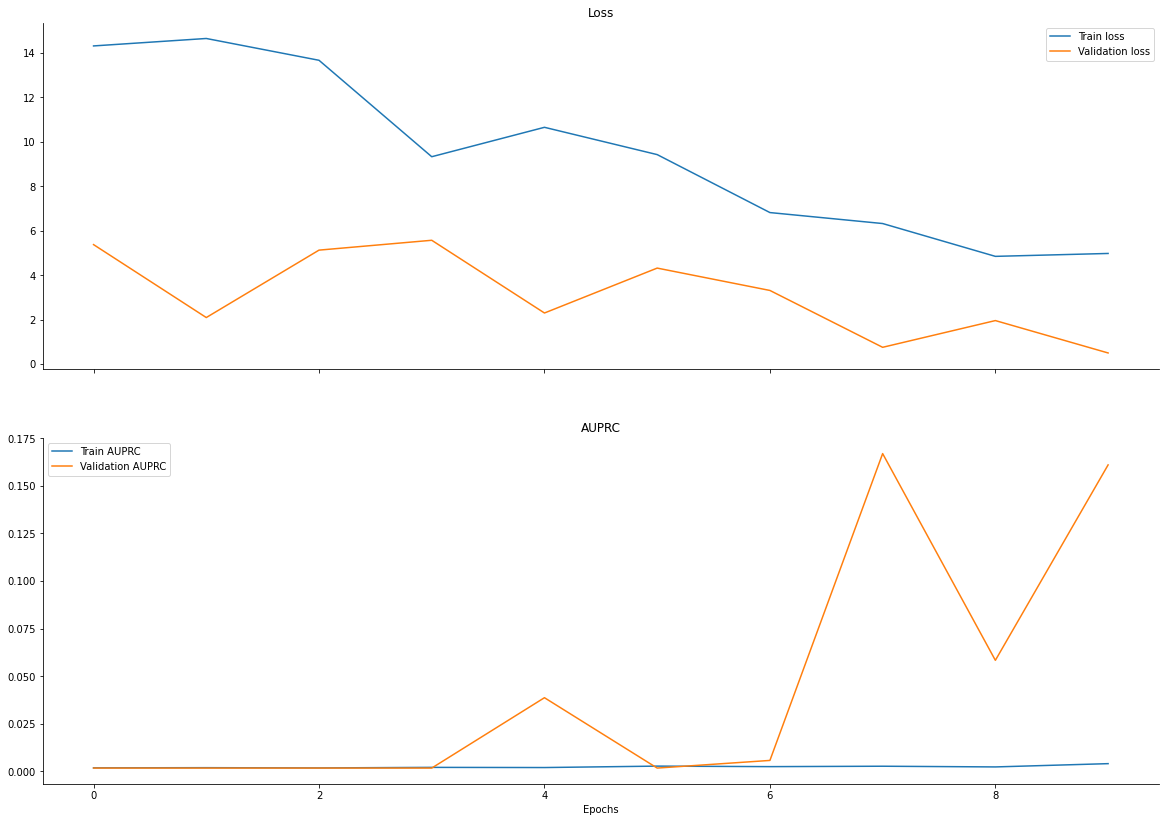

In [183]:
plot_results(history_v1)

In [185]:
def build_model():
  tf.keras.backend.clear_session()

  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.BatchNormalization(),
    layers.Dropout(0.33),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.33),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.33),
    layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])
  
  model.summary()

  return model

In [186]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3968      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [187]:
checkpoint_filepath = 'Structured-Data-Credit-Card-Fraud-Detection-v2.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                                                      monitor='val_auprc', mode='max', save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

In [188]:
EPOCHS = 10
BATCH_SIZE = 256

history_v2 = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, 
  validation_data = (normed_validation_data, validation_labels), 
  batch_size=BATCH_SIZE,
  verbose=2,
  callbacks=[model_checkpoint, early_stopping]
  )

Epoch 1/10
713/713 - 7s - loss: 0.1935 - auroc: 0.5105 - auprc: 0.0018 - val_loss: 0.0155 - val_auroc: 0.4845 - val_auprc: 0.0016
Epoch 2/10
713/713 - 7s - loss: 0.0165 - auroc: 0.5375 - auprc: 0.0022 - val_loss: 0.0128 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 3/10
713/713 - 7s - loss: 0.0146 - auroc: 0.5126 - auprc: 0.0019 - val_loss: 0.0131 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 4/10
713/713 - 7s - loss: 0.0143 - auroc: 0.5017 - auprc: 0.0018 - val_loss: 0.0129 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 5/10
713/713 - 7s - loss: 0.0138 - auroc: 0.5118 - auprc: 0.0019 - val_loss: 0.0129 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 6/10
713/713 - 7s - loss: 0.0137 - auroc: 0.5083 - auprc: 0.0018 - val_loss: 0.0128 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 7/10
713/713 - 7s - loss: 0.0136 - auroc: 0.5222 - auprc: 0.0020 - val_loss: 0.0130 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 8/10
713/713 - 7s - loss: 0.0137 - auroc: 0.5077 - auprc: 0.0018 - val_loss: 0.0126 

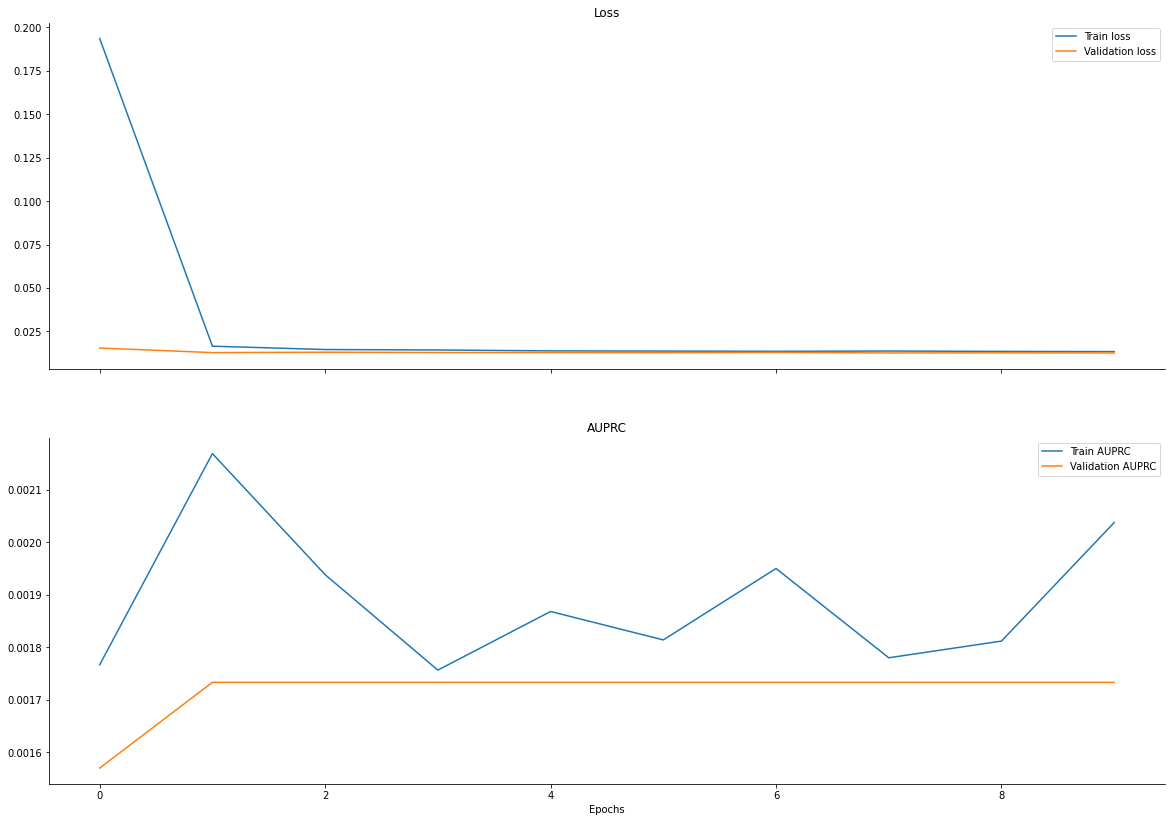

In [189]:
plot_results(history_v2)

### David's code

In [190]:
from tensorflow.keras.layers import Dense, Input, ELU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def create_model():
  tf.keras.backend.clear_session()
  input1 = Input(shape=(normed_train_data.shape[1],), name='input1')
  x = Dense(96)(input1)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  out = Dense(1, activation='sigmoid', name='out')(x)

  _model = Model(inputs=[input1], outputs=[out])
  _model.summary()

  _model.compile(optimizer=Adam(), loss='binary_crossentropy', 
                 metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])
  return _model

model = create_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
elu (ELU)                    (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)               

In [191]:
BATCH_SIZE=256

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                     monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

history = model.fit(normed_train_data, train_labels, epochs=10, verbose=2, callbacks=[es, mc], 
                    validation_data=(normed_validation_data, validation_labels), batch_size=BATCH_SIZE)

Epoch 1/10
713/713 - 7s - loss: 0.1023 - auroc: 0.5060 - auprc: 0.0018 - val_loss: 0.0131 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 2/10
713/713 - 7s - loss: 0.0169 - auroc: 0.4856 - auprc: 0.0016 - val_loss: 0.0137 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 3/10
713/713 - 7s - loss: 0.0158 - auroc: 0.5091 - auprc: 0.0020 - val_loss: 0.0136 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 4/10
713/713 - 7s - loss: 0.0153 - auroc: 0.4948 - auprc: 0.0017 - val_loss: 0.0134 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 5/10
713/713 - 7s - loss: 0.0153 - auroc: 0.5045 - auprc: 0.0018 - val_loss: 0.0130 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 6/10
713/713 - 7s - loss: 0.0150 - auroc: 0.4997 - auprc: 0.0018 - val_loss: 0.0130 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 7/10
713/713 - 7s - loss: 0.0145 - auroc: 0.5032 - auprc: 0.0018 - val_loss: 0.0132 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 8/10
713/713 - 7s - loss: 0.0143 - auroc: 0.5084 - auprc: 0.0018 - val_loss: 0.0129 

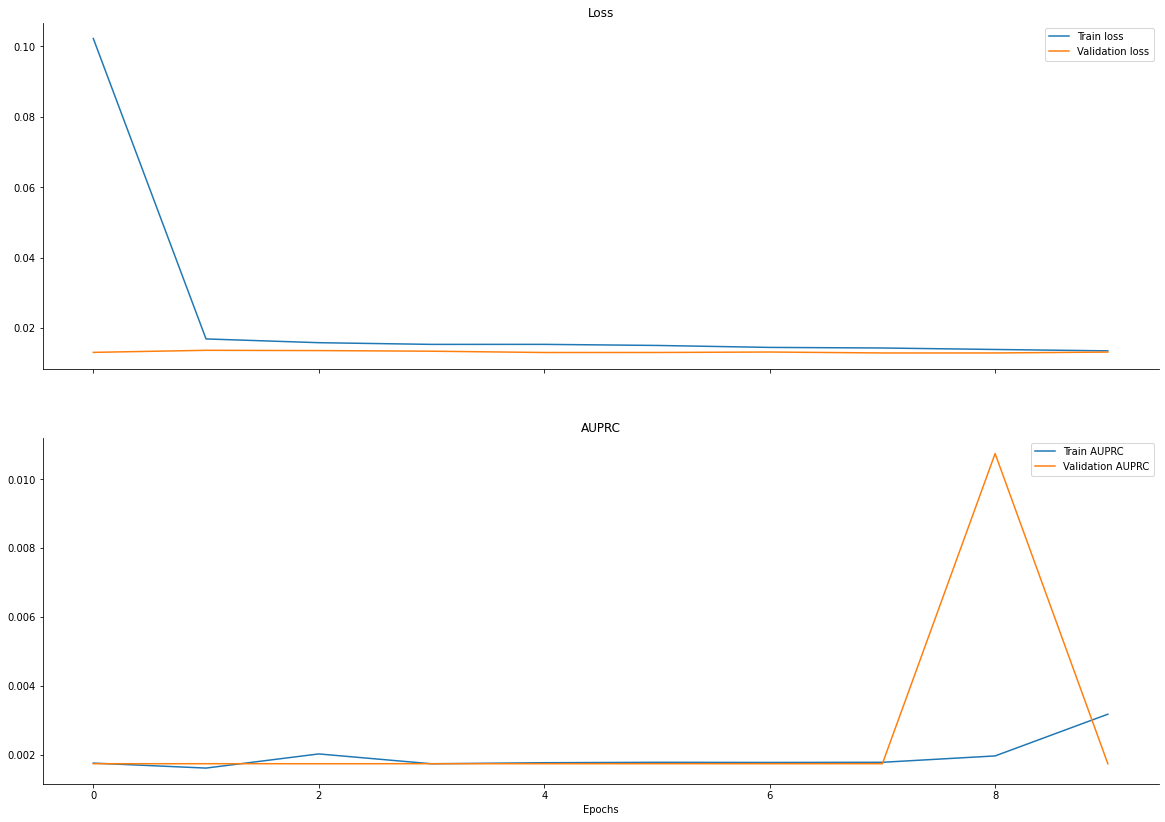

In [192]:
plot_results(history)

In [208]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [197]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [198]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, stratify=df['Class'], test_size=0.2, random_state=seed)
train_df, val_df = train_test_split(train_df, stratify=train_df['Class'], test_size=0.2, random_state=seed)

In [199]:
y_train = train_df['Class'].values
y_val = val_df['Class'].values
y_test = test_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns').values
x_val = val_df.drop(['Class'], axis='columns').values
x_test = test_df.drop(['Class'], axis='columns').values

In [200]:
from numpy import bincount
neg, pos = bincount(y_train)
total = neg + pos

In [201]:
def compute_metrics(y_true, y_pred):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(y_true, y_pred)
  tp = int(tp.result().numpy())
  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(y_true, y_pred)
  fp = int(fp.result().numpy())
  tn = tf.keras.metrics.TrueNegatives()
  tn.update_state(y_true, y_pred)
  tn = int(tn.result().numpy())
  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(y_true, y_pred)
  fn = int(fn.result().numpy())
  return [tp, fn, fp, tn]

In [202]:
tp_df = pd.DataFrame()
fn_df = pd.DataFrame()
fp_df = pd.DataFrame()
tn_df = pd.DataFrame()

In [203]:
def print_metrics(metrics):
  print('Fraudulent Transactions Detected (True Positives): ' + str(metrics[0]))
  print('Fraudulent Transactions Missed (False Negatives): ' + str(metrics[1]))
  print('Legitimate Transactions Incorrectly Detected (False Positives): ' + str(metrics[2]))
  print('Legitimate Transactions Detected (True Negatives): ' + str(metrics[3]))

In [204]:
from tensorflow.keras.layers import Dense, Input, ELU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def create_model():
  tf.keras.backend.clear_session()
  input1 = Input(shape=(x_train.shape[1],), name='input1')
  x = Dense(96)(input1)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  out = Dense(1, activation='sigmoid', name='out')(x)

  _model = Model(inputs=[input1], outputs=[out])
  _model.summary()

  _model.compile(optimizer=Adam(), loss='binary_crossentropy', 
                 metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])
  return _model

model = create_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
elu (ELU)                    (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)               

In [205]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                     monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

BATCH_SIZE=256
history = model.fit(x_train, y_train, epochs=10, verbose=2, callbacks=[es, mc], 
                    validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/10
713/713 - 7s - loss: 0.0648 - auroc: 0.8157 - auprc: 0.1931 - val_loss: 0.0052 - val_auroc: 0.9547 - val_auprc: 0.7624
Epoch 2/10
713/713 - 7s - loss: 0.0074 - auroc: 0.9068 - auprc: 0.5832 - val_loss: 0.0049 - val_auroc: 0.9365 - val_auprc: 0.7600
Epoch 3/10
713/713 - 7s - loss: 0.0056 - auroc: 0.9177 - auprc: 0.6381 - val_loss: 0.0040 - val_auroc: 0.9428 - val_auprc: 0.7725
Epoch 4/10
713/713 - 7s - loss: 0.0048 - auroc: 0.9262 - auprc: 0.6887 - val_loss: 0.0032 - val_auroc: 0.9491 - val_auprc: 0.7858
Epoch 5/10
713/713 - 7s - loss: 0.0044 - auroc: 0.9233 - auprc: 0.7011 - val_loss: 0.0030 - val_auroc: 0.9554 - val_auprc: 0.7980
Epoch 6/10
713/713 - 7s - loss: 0.0042 - auroc: 0.9315 - auprc: 0.6988 - val_loss: 0.0028 - val_auroc: 0.9366 - val_auprc: 0.8329
Epoch 7/10
713/713 - 7s - loss: 0.0041 - auroc: 0.9255 - auprc: 0.7228 - val_loss: 0.0027 - val_auroc: 0.9428 - val_auprc: 0.8299
Epoch 8/10
713/713 - 7s - loss: 0.0039 - auroc: 0.9351 - auprc: 0.7191 - val_loss: 0.0027 

In [206]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 9s 5ms/step - loss: 0.0034 - auroc: 0.9231 - auprc: 0.8012


[0.0034446322824805975, 0.9230765700340271, 0.8011783957481384]

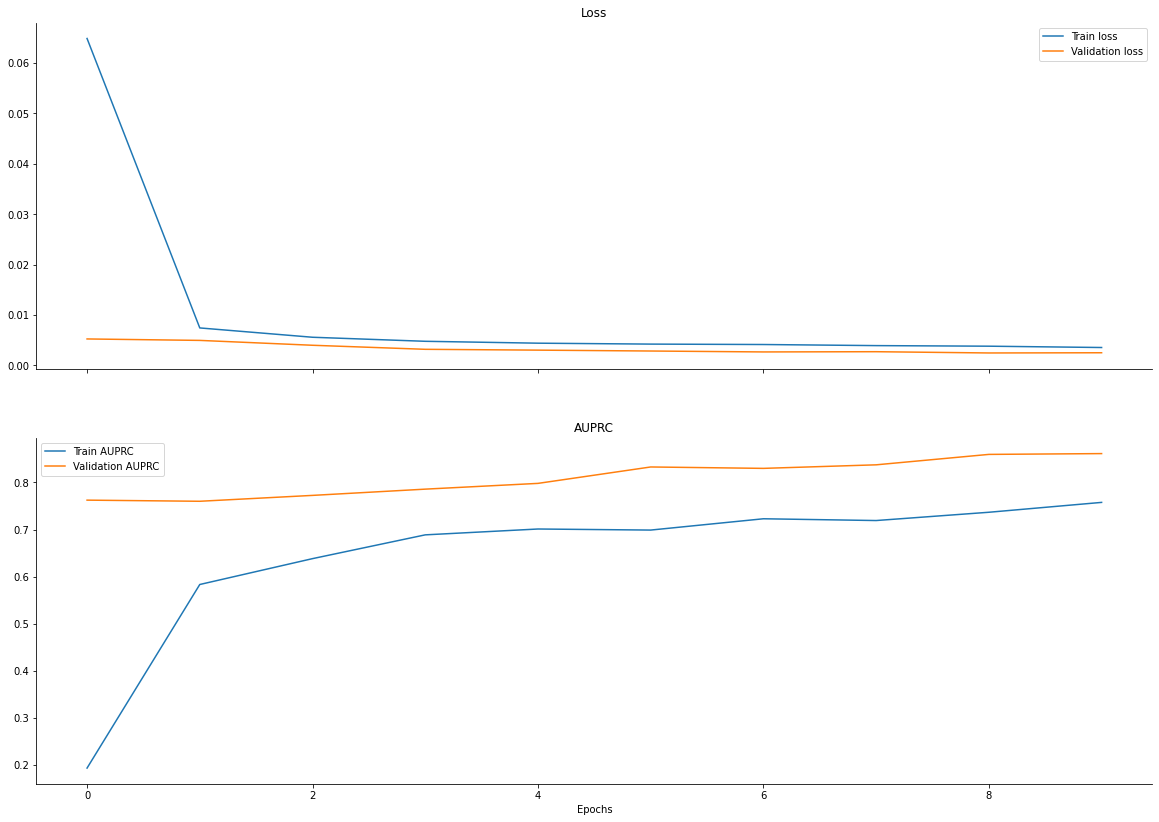

In [207]:
plot_results(history)

### No scaling done for Time and Amount

In [209]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [210]:
#from sklearn.preprocessing import RobustScaler
#scaler = RobustScaler()

#df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
#df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

#df.drop(['Time','Amount'], axis=1, inplace=True)

In [211]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, stratify=df['Class'], test_size=0.2, random_state=seed)
train_df, val_df = train_test_split(train_df, stratify=train_df['Class'], test_size=0.2, random_state=seed)

In [212]:
y_train = train_df['Class'].values
y_val = val_df['Class'].values
y_test = test_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns').values
x_val = val_df.drop(['Class'], axis='columns').values
x_test = test_df.drop(['Class'], axis='columns').values

In [214]:
neg, pos = bincount(y_train)
total = neg + pos

In [215]:
def create_model():
  tf.keras.backend.clear_session()
  input1 = Input(shape=(x_train.shape[1],), name='input1')
  x = Dense(96)(input1)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  out = Dense(1, activation='sigmoid', name='out')(x)

  _model = Model(inputs=[input1], outputs=[out])
  _model.summary()

  _model.compile(optimizer=Adam(), loss='binary_crossentropy', 
                 metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])
  return _model

model = create_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
elu (ELU)                    (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)               

In [216]:
checkpoint_filepath = 'model_no_scaling_time_amount.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                     monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

BATCH_SIZE=256
history = model.fit(x_train, y_train, epochs=10, verbose=2, callbacks=[es, mc], 
                    validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/10
713/713 - 7s - loss: 0.0920 - auroc: 0.5066 - auprc: 0.0018 - val_loss: 0.0131 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 2/10
713/713 - 7s - loss: 0.0163 - auroc: 0.5040 - auprc: 0.0017 - val_loss: 0.0138 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 3/10
713/713 - 7s - loss: 0.0156 - auroc: 0.5013 - auprc: 0.0018 - val_loss: 0.0140 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 4/10
713/713 - 7s - loss: 0.0156 - auroc: 0.4956 - auprc: 0.0017 - val_loss: 0.0134 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 5/10
713/713 - 7s - loss: 0.0153 - auroc: 0.5046 - auprc: 0.0018 - val_loss: 0.0130 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 6/10
713/713 - 7s - loss: 0.0150 - auroc: 0.4864 - auprc: 0.0016 - val_loss: 0.0131 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 7/10
713/713 - 7s - loss: 0.0146 - auroc: 0.4992 - auprc: 0.0017 - val_loss: 0.0129 - val_auroc: 0.5000 - val_auprc: 0.0017
Epoch 8/10
713/713 - 7s - loss: 0.0141 - auroc: 0.5146 - auprc: 0.0019 - val_loss: 0.0130 

In [217]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 9s 5ms/step - loss: 0.0130 - auroc: 0.5000 - auprc: 0.0017


[0.013035649433732033, 0.5, 0.001720445230603218]

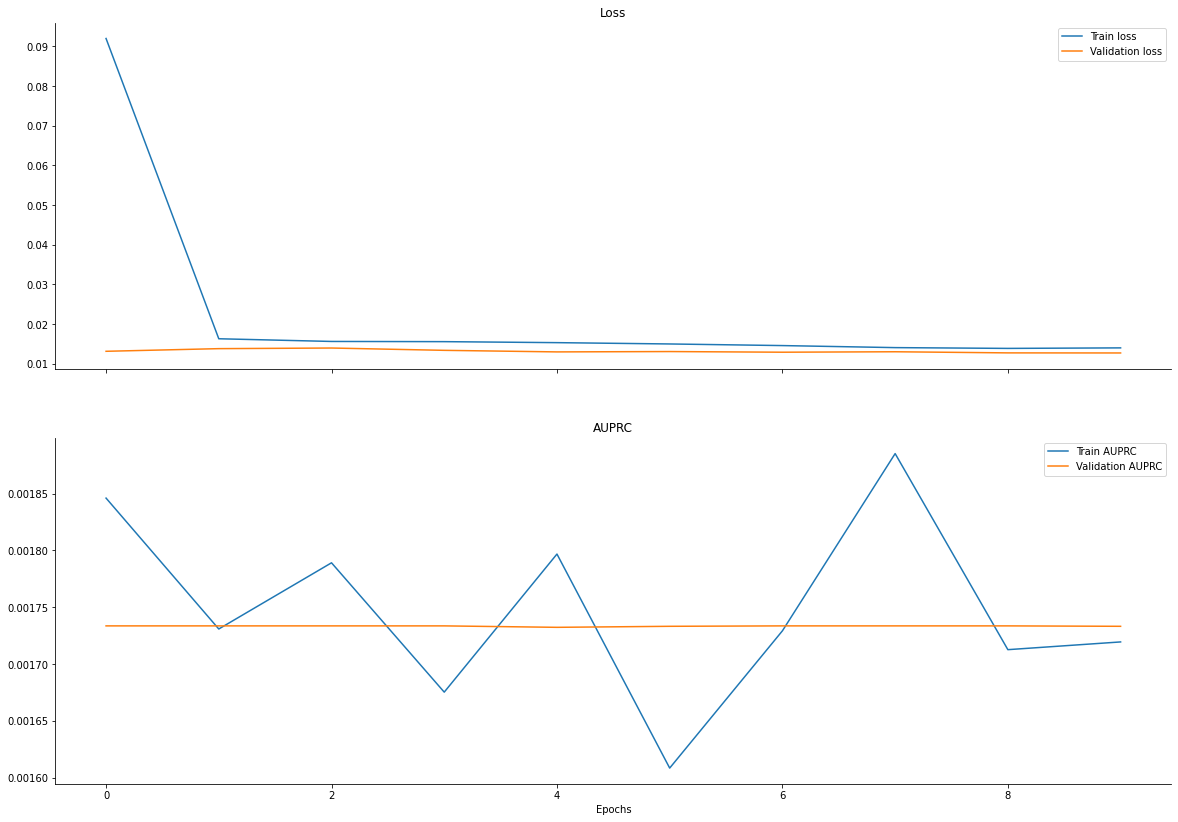

In [218]:
plot_results(history)

### My code with scaling/normalization

In [259]:
dataset = pd.read_csv(dataset_path)
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [260]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

dataset['scaled_amount'] = scaler.fit_transform(dataset['Amount'].values.reshape(-1,1))
dataset['scaled_time'] = scaler.fit_transform(dataset['Time'].values.reshape(-1,1))

dataset.drop(['Time','Amount'], axis=1, inplace=True)

### Along with having a common metric, AUPRC, for comparison, it is important to have the same test data to run the metric against. So how about we all use the following approach

In [261]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset, stratify=dataset['Class'], test_size=0.2, random_state=51)

### It is not necessary for comparison, but many people will further split the training data into training and validation via something like

In [262]:
train_dataset, validation_dataset = train_test_split(train_dataset, stratify=train_dataset['Class'], test_size=0.2, random_state=51)

In [263]:
print(train_dataset.shape, validation_dataset.shape, test_dataset.shape)

(182276, 31) (45569, 31) (56962, 31)


In [264]:
print(100*train_dataset.shape[0]/dataset.shape[0], 100*validation_dataset.shape[0]/dataset.shape[0], 100*test_dataset.shape[0]/dataset.shape[0])

63.99983146481652 15.99995786620413 20.000210668979342


In [265]:
train_labels = train_dataset.pop('Class')
validation_labels = validation_dataset.pop('Class')
test_labels = test_dataset.pop('Class')

In [266]:
def build_model():
  tf.keras.backend.clear_session()

  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.BatchNormalization(),
    layers.Dropout(0.33),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.33),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.33),
    layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])
  
  model.summary()

  return model

In [267]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3968      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [268]:
checkpoint_filepath = 'Structured-Data-Credit-Card-Fraud-Detection-v3.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                                                      monitor='val_auprc', mode='max', save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

In [269]:
EPOCHS = 100
BATCH_SIZE = 256

history_v3 = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, 
  validation_data = (validation_dataset, validation_labels), 
  batch_size=BATCH_SIZE,
  verbose=2,
  callbacks=[model_checkpoint, early_stopping]
  )

Epoch 1/100
713/713 - 7s - loss: 0.1925 - auroc: 0.7291 - auprc: 0.1118 - val_loss: 0.0125 - val_auroc: 0.9131 - val_auprc: 0.7180
Epoch 2/100
713/713 - 7s - loss: 0.0117 - auroc: 0.8799 - auprc: 0.4835 - val_loss: 0.0062 - val_auroc: 0.9365 - val_auprc: 0.7603
Epoch 3/100
713/713 - 7s - loss: 0.0072 - auroc: 0.9094 - auprc: 0.5511 - val_loss: 0.0051 - val_auroc: 0.9303 - val_auprc: 0.7471
Epoch 4/100
713/713 - 7s - loss: 0.0059 - auroc: 0.9137 - auprc: 0.6528 - val_loss: 0.0044 - val_auroc: 0.9366 - val_auprc: 0.7556
Epoch 5/100
713/713 - 7s - loss: 0.0057 - auroc: 0.9279 - auprc: 0.6206 - val_loss: 0.0044 - val_auroc: 0.9429 - val_auprc: 0.7665
Epoch 6/100
713/713 - 6s - loss: 0.0049 - auroc: 0.9220 - auprc: 0.6748 - val_loss: 0.0041 - val_auroc: 0.9366 - val_auprc: 0.7575
Epoch 7/100
713/713 - 6s - loss: 0.0046 - auroc: 0.9255 - auprc: 0.6975 - val_loss: 0.0038 - val_auroc: 0.9429 - val_auprc: 0.7750
Epoch 8/100
713/713 - 7s - loss: 0.0044 - auroc: 0.9349 - auprc: 0.7003 - val_loss:

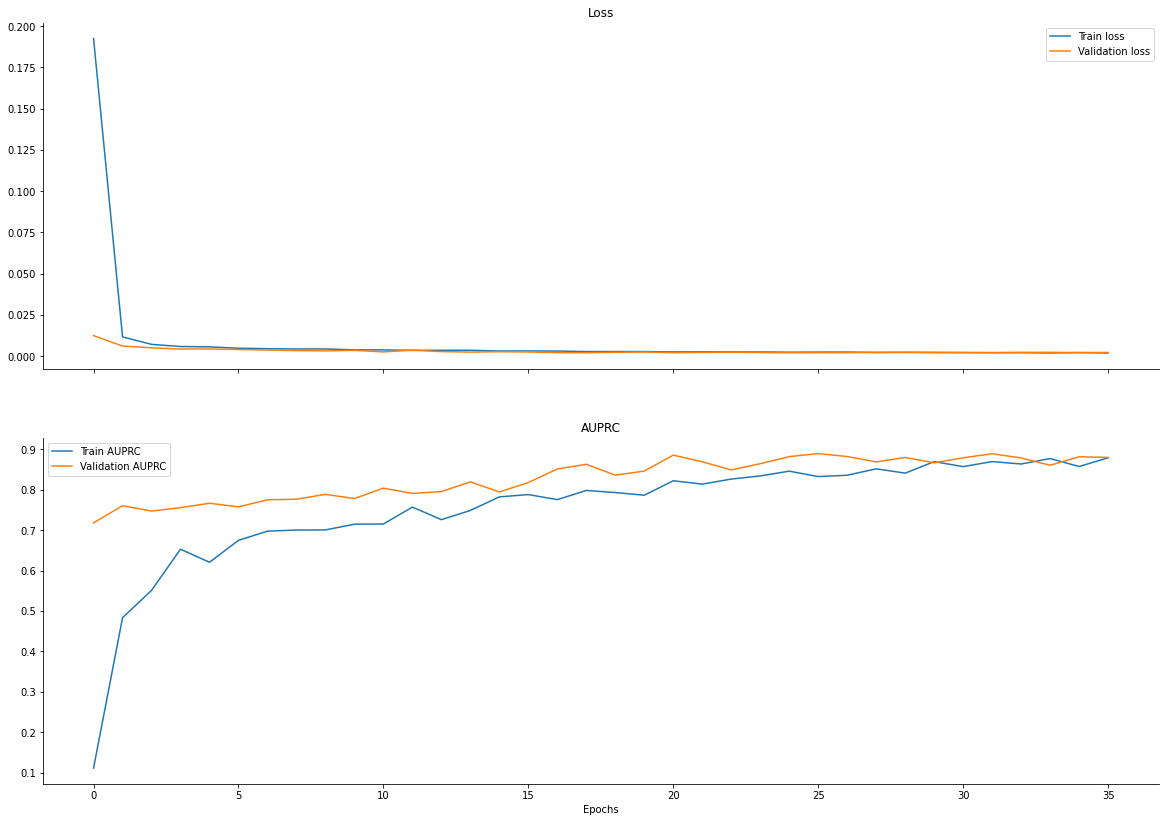

In [270]:
plot_results(history_v3)

In [271]:
y_pred = model.predict(test_dataset)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(test_labels, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.8083322

In [272]:
TF_Model_metrics = compute_metrics(test_labels, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 78
Fraudulent Transactions Missed (False Negatives): 20
Legitimate Transactions Incorrectly Detected (False Positives): 12
Legitimate Transactions Detected (True Negatives): 56852
